In [15]:
# Import các thư viện cần thiết
import torch
import learn2learn as l2l
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [16]:
# Load dữ liệu
data = pd.read_csv("../../../Dataset/ADBE_Stock.csv")
df=data.reset_index()['Close']

In [17]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [18]:
# Chia train test
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [19]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
# Tạo DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(ytest))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
# Xây dựng mô hình
class StockPredictor(nn.Module):
    def __init__(self):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [24]:
# Định nghĩa hàm meta-learning
def fast_adapt(batch, learner, loss, adaptation_steps, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    for step in range(adaptation_steps):
        predictions = learner(data).view(-1)
        train_loss = loss(predictions, labels.view(-1))
        learner.adapt(train_loss)
    return train_loss

In [25]:
# Định nghĩa quá trình training
def meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps, meta_batch_size, device):
    for epoch in range(100):
        meta_loss = 0.0
        for batch in train_loader:
            learner = maml.clone()
            batch_loss = fast_adapt(batch, learner, loss, adaptation_steps, device)
            meta_loss += batch_loss.item()
            meta_optimizer.zero_grad()
            batch_loss.backward()
            # Ensure that only leaf tensors are used to calculate the gradients
            for param in maml.parameters():
                if param.grad is not None:
                    param.grad = param.grad.clone().detach()
            meta_optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {meta_loss/len(train_loader)}')

In [26]:
# Khởi tạo mô hình và các thành phần cần thiết
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPredictor().to(device)
maml = l2l.algorithms.MAML(model, lr=0.01)
meta_optimizer = optim.Adam(maml.parameters(), lr=0.001)
loss = nn.MSELoss()

In [27]:
# Training mô hình
meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps=3, meta_batch_size=32, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:675: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Epoch 1, Loss: 0.1775288368264834
Epoch 2, Loss: 0.05361540044347445
Epoch 3, Loss: 0.03636133546630541
Epoch 4, Loss: 0.01240643865118424
Epoch 5, Loss: 0.005821133777499199
Epoch 6, Loss: 0.003786549624055624
Epoch 7, Loss: 0.0031120123186459143
Epoch 8, Loss: 0.0027418692285815873
Epoch 9, Loss: 0.0028626741686215004
Epoch 10, Loss: 0.002689750453767677
Epoch 11, Loss: 0.0026067425962537525
Epoch 12, Loss: 0.0024275282475476464
Epoch 13, Loss: 0.002391093069066604
Epoch 14, Loss: 0.0022699656741072736
Epoch 15, Loss: 0.0022361230726043384
Epoch 16, Loss: 0.0020781179579595723
Epoch 17, Loss: 0.00201426789474984
Epoch 18, Loss: 0.002012030826881528
Epoch 19, Loss: 0.0021324251700813573
Epoch 20, Loss: 0.001948164589703083
Epoch 21, Loss: 0.001982178632169962
Epoch 22, Loss: 0.0018697934302811822
Epoch 23, Loss: 0.0018844688854490717
Epoch 24, Loss: 0.0017529510504876574
Epoch 25, Loss: 0.001895013622318705
Epoch 26, Loss: 0.0019194229894007246
Epoch 27, Loss: 0.0016695521383856733
Ep

In [28]:
# Dự đoán và hiển thị kết quả trên tập test
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        x = torch.Tensor(X_test[i:i+1]).to(device)
        pred = model(x).cpu().numpy()
        predictions.append(pred)

predictions = np.array(predictions).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [29]:
# Dự báo 30 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 30):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 30 ngày tiếp theo:")
print(predicted_30_days)


Dự báo 30 ngày tiếp theo:
[[464.45158015]
 [459.66876265]
 [457.13830048]
 [455.62295415]
 [454.6075023 ]
 [453.82350462]
 [453.11975988]
 [452.41441268]
 [451.669107  ]
 [450.87185013]
 [450.02491656]
 [449.13704235]
 [448.21848851]
 [447.27866311]
 [446.3250616 ]
 [445.3629308 ]
 [444.3957341 ]
 [443.42548754]
 [442.45312157]
 [441.4790756 ]
 [440.50329791]
 [439.52560759]
 [438.54584957]
 [437.56376537]
 [436.57925161]
 [435.59217907]
 [434.60252189]
 [433.61028007]
 [432.61547946]
 [431.61814591]]


In [30]:
# Dự báo 60 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_60 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 60):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 60 ngày tiếp theo:")
print(predicted_60_days)


Dự báo 60 ngày tiếp theo:
[[464.45158015]
 [459.66876265]
 [457.13830048]
 [455.62295415]
 [454.6075023 ]
 [453.82350462]
 [453.11975988]
 [452.41441268]
 [451.669107  ]
 [450.87185013]
 [450.02491656]
 [449.13704235]
 [448.21848851]
 [447.27866311]
 [446.3250616 ]
 [445.3629308 ]
 [444.3957341 ]
 [443.42548754]
 [442.45312157]
 [441.4790756 ]
 [440.50329791]
 [439.52560759]
 [438.54584957]
 [437.56376537]
 [436.57925161]
 [435.59217907]
 [434.60252189]
 [433.61028007]
 [432.61547946]
 [431.61814591]
 [430.6183828 ]
 [429.61624183]
 [428.61182637]
 [427.60523983]
 [426.59657265]
 [425.58588945]
 [424.57335824]
 [423.55904363]
 [422.54307485]
 [421.52558114]
 [420.50664003]
 [419.48643245]
 [418.46502301]
 [417.44259264]
 [416.41924473]
 [415.39513435]
 [414.37041658]
 [413.34518188]
 [412.31964995]
 [411.29391124]
 [410.26814669]
 [409.24251138]
 [408.21713452]
 [407.19222291]
 [406.16791868]
 [405.14438984]
 [404.12177855]
 [403.10030449]
 [402.08009691]
 [401.06133673]]


In [31]:
# Dự báo 90 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_90 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 90):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 90 ngày tiếp theo:")
print(predicted_90_days)

Dự báo 90 ngày tiếp theo:
[[464.45158015]
 [459.66876265]
 [457.13830048]
 [455.62295415]
 [454.6075023 ]
 [453.82350462]
 [453.11975988]
 [452.41441268]
 [451.669107  ]
 [450.87185013]
 [450.02491656]
 [449.13704235]
 [448.21848851]
 [447.27866311]
 [446.3250616 ]
 [445.3629308 ]
 [444.3957341 ]
 [443.42548754]
 [442.45312157]
 [441.4790756 ]
 [440.50329791]
 [439.52560759]
 [438.54584957]
 [437.56376537]
 [436.57925161]
 [435.59217907]
 [434.60252189]
 [433.61028007]
 [432.61547946]
 [431.61814591]
 [430.6183828 ]
 [429.61624183]
 [428.61182637]
 [427.60523983]
 [426.59657265]
 [425.58588945]
 [424.57335824]
 [423.55904363]
 [422.54307485]
 [421.52558114]
 [420.50664003]
 [419.48643245]
 [418.46502301]
 [417.44259264]
 [416.41924473]
 [415.39513435]
 [414.37041658]
 [413.34518188]
 [412.31964995]
 [411.29391124]
 [410.26814669]
 [409.24251138]
 [408.21713452]
 [407.19222291]
 [406.16791868]
 [405.14438984]
 [404.12177855]
 [403.10030449]
 [402.08009691]
 [401.06133673]
 [400.04423071

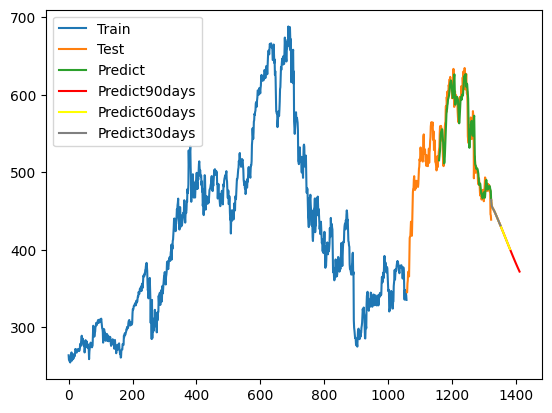

In [32]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(predictions))
predict_data_index_90 = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
predict_data_index_60 = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
predict_data_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

In [33]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((predictions - ytest) ** 2))
test_mape = calculate_mape(ytest, predictions)
test_mae = calculate_mae(ytest, predictions)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 551.1931013197749
Testing MAPE: 81825.90679083145
Testing MAE: 548.7772184294064
